The design is pretty simple to begin with. I want to get better at trading swing and positional and develop an eye for explosive setups (both long and short). So, I want to practice. The idea is to:

1. Select a random scrip
2. Load a random slice of time of period 'n'
3. Give initial sum of money
4. Make a call: Buy/Sell/None 
5. Load chart further to see what happened. Keep score of win/lose/skips. Could also keep the data range that was shown for future analysis.

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
#Import basic libraries
#%matplotlib widget
%matplotlib inline


import os
import sys
import settings
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from django_pandas.io import read_frame
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates

from matplotlib.dates import date2num

#Prepare to load stock data as pandas dataframe from source. In this case, prepare django
import django
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'rest.settings')
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
django.setup()

from stocks.models import Listing, Stock, Market
from lib.retrieval import get_stock_listing

#Import TA-lib and backtesting library
import talib
from talib.abstract import *
from talib import MA_Type

from backtesting import Strategy
from backtesting import Backtest
from backtesting.lib import crossover

import mplfinance as mpf
import mplcursors

/mnt/c/Users/anshu/Documents/experimental/env/lib/python3.8/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [3]:
from random import randrange
from datetime import timedelta
from datetime import datetime

def random_date(start = datetime.strptime('1/1/2012', '%m/%d/%Y'), end=None):
    """
    This function will return a random datetime between two datetime 
    objects.
    """
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    return start + timedelta(seconds=random_second)

In [ ]:
# Install a pip package in the current Jupyter kernel
#import sys
#!{sys.executable} -m pip install websocket websocket-client selenium --upgrade --no-cache-dir
from tvDatafeed_edge import TvDatafeed, Interval

username = 'blasphemous_aesthete'
password = 'anshulthakur@123'

tv = TvDatafeed(username, password, auto_login=True)
#tv  = TvDatafeed(auto_login=False)

In [19]:
score = {'draws': 0, 'long': 0, 'short': 0, 'pass': 0, 'success': 0, 'failure': 0}
history = []

duration = 150
test_day = 90
init_capital = 50000

current_capital = init_capital

RASHTRIYA CHEMICALS & FERTILIZERS LTD.(RCF)
150


<Mpf_Figure size 1200x1000 with 0 Axes>

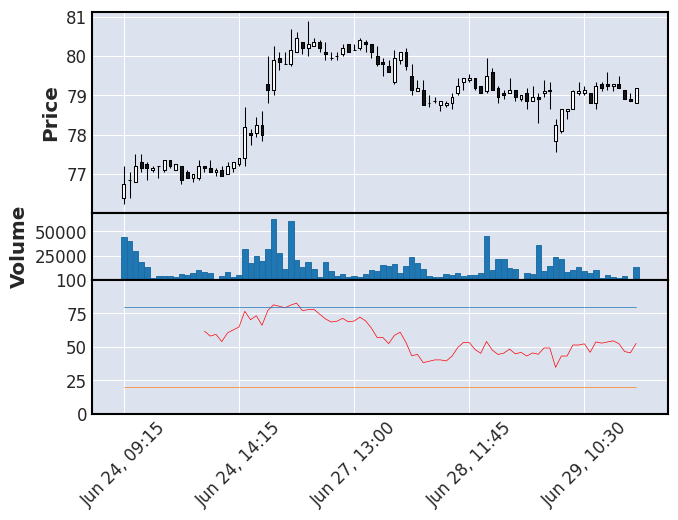

In [74]:
find_new_stock = True
stock = None
df = None
stop_date = datetime.today()
use_tradingview = True

if use_tradingview:
    while find_new_stock:
        stock = Stock.objects.random()
        print(f'{stock.name}({stock.sid})')
        df = tv.get_hist(
                stock.sid,
                "BSE",
                interval=Interval.in_15_minute,
                n_bars=150,
                extended_session=False,
            )
        if len(df) > test_day:
            df['rsi'] = talib.RSI(df['close'], 14)
            df['rsi_overbought'] = [80.]*len(df)
            df['rsi_oversold']   = [20.]*len(df)
            find_new_stock = False
else:
    while find_new_stock:
        stock = Stock.objects.random()
        end_date = random_date(end=stop_date)
        df = get_stock_listing(stock=stock, duration=duration, last_date=end_date)
        #print(len(df))
        if len(df) > test_day:
            df['rsi'] = talib.RSI(df['close'], 14)
            df['rsi_overbought'] = [80.]*len(df)
            df['rsi_oversold']   = [20.]*len(df)
            find_new_stock = False
    print(f'{stock.name}({stock.sid})')
    
print(len(df))
df_test = df.iloc[0:test_day]

fig = mpf.figure(style='yahoo', figsize=(12,10))
ap2 = [ mpf.make_addplot(df['rsi'][0:test_day],color='r',panel=2, width=0.5, ylim=[0,100]),
        mpf.make_addplot(df['rsi_overbought'][0:test_day], secondary_y=False, panel=2, width=0.5),
      mpf.make_addplot(df['rsi_oversold'][0:test_day], secondary_y=False, panel=2, width=0.5),]  # panel 2 specified
       
mpf.plot(df_test, type='candle', volume=True, main_panel=0,volume_panel=1, addplot=ap2, panel_ratios=(3,1,2))

#ax.set_title("Click somewhere on a line.\nRight-click to deselect.\n"
#             "Annotations can be dragged.")

mplcursors.cursor()  # or just mplcursors.cursor()

#plt.show()

In [75]:
move_l = input('Bet? [(L)ong/(S)hort/(N)one Target StopLoss]')
if current_capital<0:
    print("You don't have capital to trade.")

Bet? [(L)ong/(S)hort/(N)one Target StopLoss]L 80.1 78.6


In [76]:
move_l = move_l.split(' ')
move = None
if len(move_l)>0:
    if len(move_l)==1:
        move  = {'move': 'None',
                 'sid': stock.sid,
                 'start': df.index[0],
                 'end': df.index[test_day],
                 'target': 0,
                 'stoploss': 0,
                 'cmp': df.open[test_day],
                 'result': 0
                }
    else:
        move = {'move': 'Long' if move_l[0].strip().lower().startswith('l') else 'Short',
                'sid': stock.sid,
                'start': df.index[0],
                'end': df.index[test_day],
                'target': float(move_l[1]),
                'stoploss': float(move_l[2]),
                'cmp': df.open[test_day]}
else:
    move = {'move': 'None',
            'sid': stock.sid,
            'start': df.index[0],
            'end': df.index[test_day],
            'target': 0,
            'stoploss': 0,
            'cmp': df.open[test_day],
            'result': 0}
    
history.append(move)

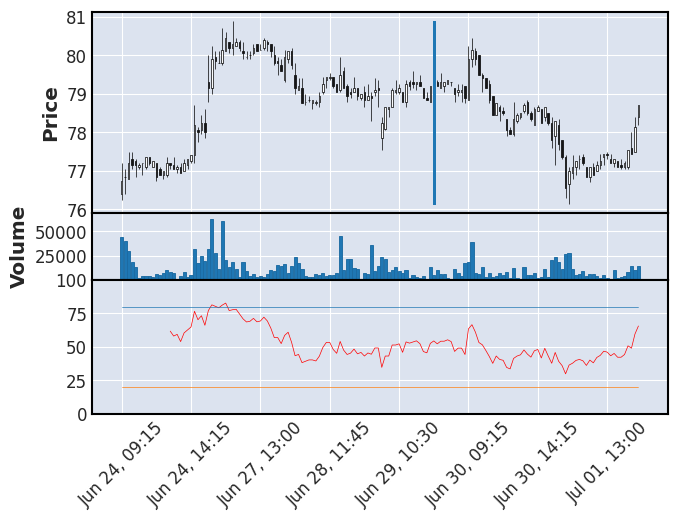

In [77]:
#mpf.plot(df, type='candle', vlines=dict(vlines=[df.index[39]]), volume=True)
ap2 = [ mpf.make_addplot(df['rsi'],color='r',panel=2, width=0.5, ylim=[0,100]),
        mpf.make_addplot(df['rsi_overbought'], secondary_y=False, panel=2, width=0.5),
        mpf.make_addplot(df['rsi_oversold'], secondary_y=False, panel=2, width=0.5),]  # panel 2 specified
       
mpf.plot(df, type='candle', 
         vlines=dict(vlines=[df.index[test_day]]), 
         volume=True, 
         main_panel=0,volume_panel=1, addplot=ap2, panel_ratios=(3,1,2))

In [78]:
score['draws'] +=1

def find_result(data, test_day, move):
    result = {'success': 0,
              'reward': 0}
    if move['move'] == 'Long':
        for day in range(test_day, max(len(df), test_day+7)):
            if data['high'][day] >= move['target']:
                result['success'] = 1
                result['reward'] = move['target'] - move['cmp']
                break
            if data['low'][day] < move['stoploss']:
                result['success'] = 0
                result['reward'] = move['stoploss'] - move['cmp']
                break
    elif move['move'] == 'Short':
        for day in range(test_day, max(len(df), test_day+7)):
            if data['low'][day] <= move['target']:
                result['success'] = 1
                result['reward'] = move['cmp'] - move['target']
                break
            if data['low'][day] > move['stoploss']:
                result['success'] = 0
                result['reward'] = move['cmp'] - move['stoploss']
                break
    return result

result = find_result(df, test_day, move)
print(result)
if move['move'] != 'None' and (current_capital//move['cmp']) > 0:
    current_capital += ((current_capital//move['cmp'])*result['reward'])
    
if move['move'] != 'None':
    if move['move'].strip().lower() == 'l':
        score['long'] += 1
    elif move['move'].strip().lower() == 's':
        score['short'] += 1    
    result = input('Result? [(W)in/(L)ose]')
    if result.strip().lower() == 'w':
        result = 1
        score['success'] +=1
    elif result.strip().lower() == 'l':
        result = -1
        score['failure'] +=1
    else:
        print('Invalid answer {}. Taking as Loss.'.format(result.strip().lower()))
        result = -1
        score['failure'] +=1
        
    history[-1]['result'] = result
else:
    score['pass'] += 1

{'success': 1, 'reward': 1.0499999999999972}
Result? [(W)in/(L)ose]W


In [79]:
print(score)
print(current_capital)

{'draws': 8, 'long': 0, 'short': 0, 'pass': 2, 'success': 2, 'failure': 4}
50730.2
